# Flatness v.s. Generalization (part 1)

## 采用的模型

| Model                                                        | Activation |
| :----------------------------------------------------------- | :-------: |
| mnist：  `Conv(16, (3x3))->Pool(2)->Conv(16, (3x3))->Conv(16, (3x3))->Conv(16, (3x3))->Pool(2)->Conv(10, (1x1))->Pool(7)` |   ReLU    |

> 训练采用的参数：
> 1. `batch_size=64, optimizer=Adam(lr=1e-3, amsgrad=True), epoch=40 `
> 2. `batch_size=1024, optimizer=Adam(lr=1e-3, amsgrad=True), epoch=40 `
> 3. `batch_size=512, optimizer=Adam(lr=1e-2, amsgrad=True), epoch=40 `
> 4. `batch_size=512, optimizer=Adam(lr=1e-3, amsgrad=True), epoch=40 `

In [1]:
import sys
sys.path.insert(0, '..')
import os
import torch
import numpy as np
from argparse import Namespace
from torch import optim
from collections import OrderedDict
from utils import eval_model, Logger
from model import cross_entropy_loss, accuracy
from model import deep_mnist
from dataset import mnist_train_loader, mnist_validate_loader
from solver import HW1Solver

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 设置参数 --- 你可以令visdom=True, 然后在http://localhost:8097上看训练过程
root = os.path.join(os.path.expanduser('~'), 'data')
config = {'batch_size': 1024, 'epochs': 40, 'resume': '', 'verbosity': 1, 'use_cuda': True,
          'lr': 1e-3, 'save_dir': '../pretrained/1_3_3', 'save_freq': 10, 'save_grad': False,
          'data_dir': root, 'dataset': 'mnist', 'valid': True, 'val_step': 1,
          'visdom': False, 'visdom_iter': True, 'visdom_fit': False}
config = Namespace(**config)
param_list = [[64, 1e-3], [1024, 1e-3], [512, 1e-3], [512, 1e-2]]

In [ ]:
# 训练阶段  --- 可能需要花费几十分钟, 请耐心等待～
# ---友情提示: 你也可以直接使用提供的已训练好的模型, 那么你就别运行这部分了 ---
for param in param_list:
    config.batch_size, config.lr = param[0], param[1]
    train_loader = mnist_train_loader(root, config.batch_size)
    val_loader = mnist_validate_loader(root, config.batch_size)
    model = deep_mnist('mnist_{}_{}'.format(config.batch_size, str(config.lr)))
    optimizer = optim.Adam(model.parameters(), config.lr, amsgrad=True)
    loss = cross_entropy_loss
    metrics = [accuracy]
    solver = HW1Solver(model, optimizer, loss, metrics, train_loader, val_loader, config)
    solver.train()

In [ ]:
# 计算不同alpha时的结果, 并保存下来 (注意：该部分可能需要运行几十分钟)
# ---友情提示: 你也可以直接使用提供的已训练好的模型, 那么你就别运行这部分了 ---
model_list = ['{}/mnist_{}_{}_epoch{}.pth.tar'.format(config.save_dir, p[0], p[1], config.epochs) for p in param_list]
logger_list = [Logger(), Logger()]
p_list = [[torch.load(model_list[0])['state_dict'], torch.load(model_list[1])['state_dict']], 
          [torch.load(model_list[2])['state_dict'], torch.load(model_list[3])['state_dict']]]
metric, loss, model = accuracy, cross_entropy_loss, deep_mnist()
train_loader = mnist_train_loader(root, config.batch_size)
val_loader = mnist_validate_loader(root, config.batch_size)
for alpha in np.arange(-1.0, 2.0, 0.02):
    log = [{'alpha': alpha}, {'alpha': alpha}]
    for i in range(2):
        alpha = float(alpha)
        param = OrderedDict((k, (1 - alpha) * p_list[i][0][k] + alpha * p_list[i][1][k]) for k in p_list[i][0])
        model.load_state_dict(param)
        res = eval_model(model, train_loader, loss, metric, config.use_cuda)
        log[i].update({'loss': res[0], 'accuracy': res[1]})
        res = eval_model(model, val_loader, loss, metric, config.use_cuda)
        log[i].update({'val_loss': res[0], 'val_accuracy': res[1]})
        logger_list[i].add_entry(log[i])
torch.save({'logger1': logger_list[0], 'logger2': logger_list[1]}, os.path.join(config.save_dir, 'logger.pth.tar'))

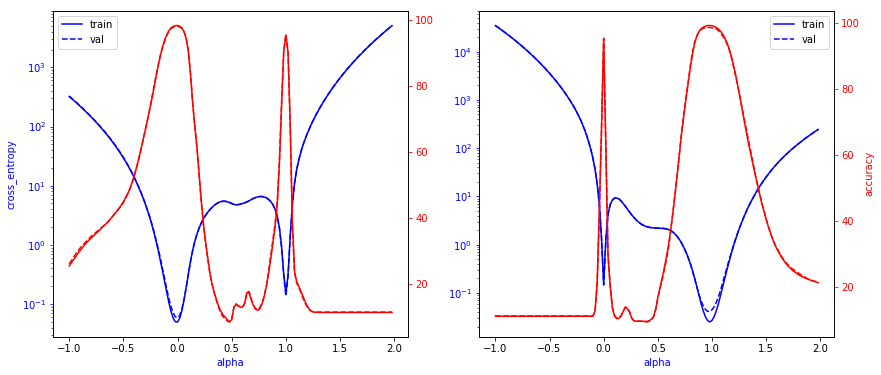

In [4]:
# 可视化结果
logger = torch.load(config.save_dir+'/logger.pth.tar')
logger_list = [logger[key] for key in logger]
x = [entry['alpha'] for _, entry in logger_list[0].entries.items()]
loss_train = [[entry['loss'] for _, entry in logger.entries.items()] for logger in logger_list]
accuracy_train = [[entry['accuracy'] for _, entry in logger.entries.items()] for logger in logger_list]
loss_val = [[entry['val_loss'] for _, entry in logger.entries.items()] for logger in logger_list]
accuracy_val = [[entry['val_accuracy'] for _, entry in logger.entries.items()] for logger in logger_list]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.semilogy(x, loss_train[0], 'b', label='train'), ax2.semilogy(x, loss_train[1], 'b', label='train')
ax1.semilogy(x, loss_val[0], 'b--', label='val'), ax2.semilogy(x, loss_val[1], 'b--', label='val')
ax1.legend(loc="best"), ax2.legend(loc="best")
ax1.tick_params('y', colors='b'), ax2.tick_params('y', colors='b')
ax1.set_xlabel('alpha', color='b'), ax2.set_xlabel('alpha', color='b')
ax12, ax22 = ax1.twinx(), ax2.twinx()
ax12.plot(x, accuracy_train[0], 'r'), ax22.plot(x, accuracy_train[1], 'r')
ax12.plot(x, accuracy_val[0], 'r--'), ax22.plot(x, accuracy_val[1], 'r--')
ax12.tick_params('y', colors='r'), ax22.tick_params('y', colors='r')
ax1.set_ylabel('cross_entropy', color='b'), ax22.set_ylabel('accuracy', color='r')
plt.show()

### 结果分析

1. 左图中alpha=0.0的对应batch_size=64, alpha=1.0对应batch_size=1024的情况; 可以发现batch_size比较小的时候，最后到达的损失值更小（但也可能是大batch没有充分收敛），此外似乎大batch_size走到的区域更陡峭，这可能导致该区域泛化性能不好
2. 右图中alpha=0.0的对应lr=1e-3，alpha=1.0对应lr=1e-2的情况；奇葩的发现学习率较小的时候反而落到了更陡峭的地方！？不知道是偶然还是其他情况